# Bibliotecas

A lista completa de bibliotecas e suas respectivas versões está contida no arquivo "requirements.txt". É extremamente recomendado a utilização de um ambiente conda próprio para utilização desse código.

In [71]:
import neurokit2 as nk
import numpy as np
from datetime import datetime
import serial
import time
import os
from datetime import datetime
import matplotlib.pyplot as plt


# Retirada dos dados do dispositivo eletrônico

### Criar pasta para cada paciente

A criação da pasta é a primeira etapa principal. Antes de receber os dados do dispositivo, substitua `Paciente1` pelo nome do seu paciente, dessa forma cada paciente terá sua própria pasta.

In [ ]:
nome_do_paciente = "Paciente1"

os.makedirs("Pacientes", exist_ok=True)
os.makedirs(f'Pacientes/{nome_do_paciente}', exist_ok=True)

Com as pastas criadas, vamos estabelecer uma função que irá criar as pastas que receberão os `outputs` gerados pelos dados do dispositivo.

In [108]:
os.makedirs(f'Pacientes/{nome_do_paciente}/Dados', exist_ok=True)
os.makedirs(f'Pacientes/{nome_do_paciente}/Concatenados', exist_ok=True)
os.makedirs(f'Pacientes/{nome_do_paciente}/Gráficos', exist_ok=True)

### Recebimento dos arquivos via Bluetooh (NECESSÁRIO RODAR COM A ESP32)

**É NECESSÁRIO RODAR ESSA CELULA COM A ESP32 NO MODO BLUETOOTH. CASO ESTEJA REVISANDO O CÓDIGO SEM A ESP32 NO GITHUB DO PROJETO EXISTE A PASTA "Paciente_teste" NO DIRETORIO "Paciente/" PARA RODAR OS CÓDIGOS DE ANALISE.**

In [92]:
def conectar_bluetooth():
    porta = 'COM8'
    taxa_bauds = 9600
    try:
        conexao = serial.Serial(porta, taxa_bauds)
        print("Conectado ao dispositivo")
        return conexao
    except Exception as e:
        print(f"Erro ao conectar: {e}")
        return None

def receber_arquivos(conexao, caminho_dados):
    print("Aguardando arquivos...")
    arquivo_atual = None
    while True:
        linha = conexao.readline().decode().strip()
        
        if linha == "FIM_TRANSFERENCIA":
            print("Transferência concluída.")
            if arquivo_atual:
                arquivo_atual.close()
            break
        elif linha.startswith("ECG_") and linha.endswith(".txt"):
            if arquivo_atual:
                arquivo_atual.close()
            nome_arquivo = os.path.join(caminho_dados, linha)
            print(f"Recebendo arquivo: {nome_arquivo}")
            arquivo_atual = open(nome_arquivo, 'w')
        elif linha == "FIM_ARQUIVO":
            print("Arquivo recebido.")
            if arquivo_atual:
                arquivo_atual.close()
                arquivo_atual = None
        else:
            if arquivo_atual:
                arquivo_atual.write(linha + '\n')

def concatenar_arquivos(caminho_dados, caminho_concatenados):
    arquivos_dados = sorted(os.listdir(caminho_dados))
    caminho_concatenado = os.path.join(caminho_concatenados, "ECG_Concatenado.txt")
    
    with open(caminho_concatenado, 'w') as arquivo_concatenado:
        header_incluido = False
        data_inicio = None
        data_fim = None
        
        for nome_arquivo in arquivos_dados:
            caminho_arquivo = os.path.join(caminho_dados, nome_arquivo)
            with open(caminho_arquivo, 'r') as arquivo:
                for idx, linha in enumerate(arquivo):
                    if idx == 0 and not header_incluido:
                        # Supõe que a data e hora estão na primeira linha do primeiro arquivo
                        data_inicio = linha.strip() if not data_inicio else data_inicio
                        arquivo_concatenado.write(f"INICIO: {data_inicio}\n")
                        arquivo_concatenado.write(linha)  # Escreve cabeçalho
                        header_incluido = True
                    elif idx != 0:
                        arquivo_concatenado.write(linha)  # Escreve linhas de dados normais
            # Atualiza a data de término com a última linha do arquivo processado
            data_fim = linha.strip()  # Supõe que a última linha de cada arquivo contém a data e hora de término
        
        if data_fim:
            arquivo_concatenado.write(f"\nFINAL: {data_fim}\n")
    
    print(f"Arquivo concatenado salvo em: {caminho_concatenado}")

def enviar_comando(conexao, comando):
    conexao.write(comando.encode())
    time.sleep(1)  # Pausa para garantir que o comando seja enviado

def main():

    caminho_base = f'Pacientes/{nome_do_paciente}'
    caminho_dados = os.path.join(caminho_base, 'Dados')
    caminho_concatenados = os.path.join(caminho_base, 'Concatenados')

    conexao = conectar_bluetooth()
    if conexao:
        enviar_comando(conexao, '1')  # Envia comando '1' para iniciar a transferência, pois no código da esp32 esse é o "gatilho" de envio.
        receber_arquivos(conexao, caminho_dados)
        conexao.close()
        concatenar_arquivos(caminho_dados, caminho_concatenados)

if __name__ == "__main__":
    main()


Conectado ao dispositivo
Aguardando arquivos...
Recebendo arquivo: Pacientes/Paciente_AumentoSR\Dados\ECG_1.txt
Arquivo recebido.
Recebendo arquivo: Pacientes/Paciente_AumentoSR\Dados\ECG_2.txt
Arquivo recebido.
Recebendo arquivo: Pacientes/Paciente_AumentoSR\Dados\ECG_3.txt
Arquivo recebido.
Transferência concluída.
Arquivo concatenado salvo em: Pacientes/Paciente_AumentoSR\Concatenados\ECG_Concatenado.txt


# Análises

## Leitura e Processamento dos Dados de ECG

Nesta etapa, lemos o arquivo de dados de ECG em formato `.txt`, que contém na primeira linha a data e a hora de criação do `.txt` seguido das leituras de ECG em valores inteiros e finalizado com a data e a hora de finalização dessa leitura. Esses dados são essenciais para garantir que temos um histórico completo e preciso dos sinais ao longo de 1 minuto ou mais. Após carregar as informações, calculamos a taxa de amostragem, ou `sample rate`, que indica a frequência com que as amostras foram capturadas.

A **taxa de amostragem** é calculada com base na média dos intervalos de tempo entre cada leitura, usando a fórmula:

$$ \text{sr} = \frac{N_{Amostras}}{\text{Duração Total}} $$

Onde `sr` é a taxa de amostragem em Hz (amostras por segundo). Esse valor é crucial para análises precisas, pois garante que todas as funções e algoritmos interpretem corretamente o intervalo de tempo entre as amostras.

In [105]:
sinal_n = []
inicio_timestamp = None
fim_timestamp = None
nome_do_paciente = 'André'

caminho = f'Pacientes/{nome_do_paciente}/Dados/ECG_4.txt'

with open(caminho, 'r') as file:
    for linha in file:
        linha = linha.strip()
        if linha.startswith("INICIO:"):
            # Ignora a linha `INICIO:`, o próximo timestamp será capturado
            continue
        elif inicio_timestamp is None:
            # Captura o timestamp inicial
            inicio_timestamp = datetime.strptime(linha, "%d/%m/%Y %H:%M:%S")
        elif linha.startswith("Leitura"):
            # Ignora linha de cabeçalho como `Leitura(ECG)`
            continue
        elif linha.isdigit():
            # Adiciona apenas leituras numéricas ao sinal
            sinal_n.append(int(linha))
        elif linha.startswith("FIM:"):
            try:
                # Captura o timestamp final
                fim_timestamp = datetime.strptime(linha.split(":")[1].strip(), "%d/%m/%Y %H:%M:%S")
            except (IndexError, ValueError):
                fim_timestamp = None  # Trata casos onde FIM não contém timestamp válido

if inicio_timestamp and fim_timestamp:
    duracao_total = (fim_timestamp - inicio_timestamp).total_seconds()
else:
    duracao_total = 60.0 # Duração total da leitura, mudar caso seja outra.

# Calcula a frequência de amostragem com base no número total de amostras e duração
numero_amostras = len(sinal_n)
sr = numero_amostras / duracao_total
print(f"Frequência de amostragem calculada: {sr:.2f} Hz")
print(f"Duração total do sinal: {duracao_total:.2f} segundos")

# Processa automaticamente o sinal de ECG bruto
sinais, info = nk.ecg_process(sinal_n, sampling_rate=sr)

picos_r = info["ECG_R_Peaks"] # Localização dos picos R

ecg_limpo = sinais["ECG_Clean"] # Limpar o ECG

# Calcula os intervalos RR
intervalos_rr = np.diff(picos_r) / sr  # Divide por 'sr' para converter de amostras para segundos

# Calcula a frequência cardíaca instantânea para cada intervalo RR
frequencia_cardiaca_instantanea = 60 / intervalos_rr  # Converte RR intervalos para BPM

# Calcula a frequência cardíaca média
frequencia_cardiaca_media = np.mean(frequencia_cardiaca_instantanea)

HR = frequencia_cardiaca_media

print(f"Frequência Cardíaca Média: {frequencia_cardiaca_media:.2f} BPM")


Frequência de amostragem calculada: 121.45 Hz
Duração total do sinal: 60.00 segundos
Frequência Cardíaca Média: 87.44 BPM


## Perfil da Frequência Média Cardíaca

Por meio dessa análise podemos identificar se o padrão ECG pode ser reconhecido visualmente para saber se a coleta de dados foi bem-sucedida. Esse gráfico é montado pegando todos os padrões ECG e sobrepondo eles em um único padrão. A `linha vermelha` é marcada pelo maior número de padrões sobrepostos, virando a média. As `linhas cinzas` são os padrões que não seguem a média. Dessa forma, podemos analisar se a coleta de dados foi boa, dado o menor número de linhas cinzas.

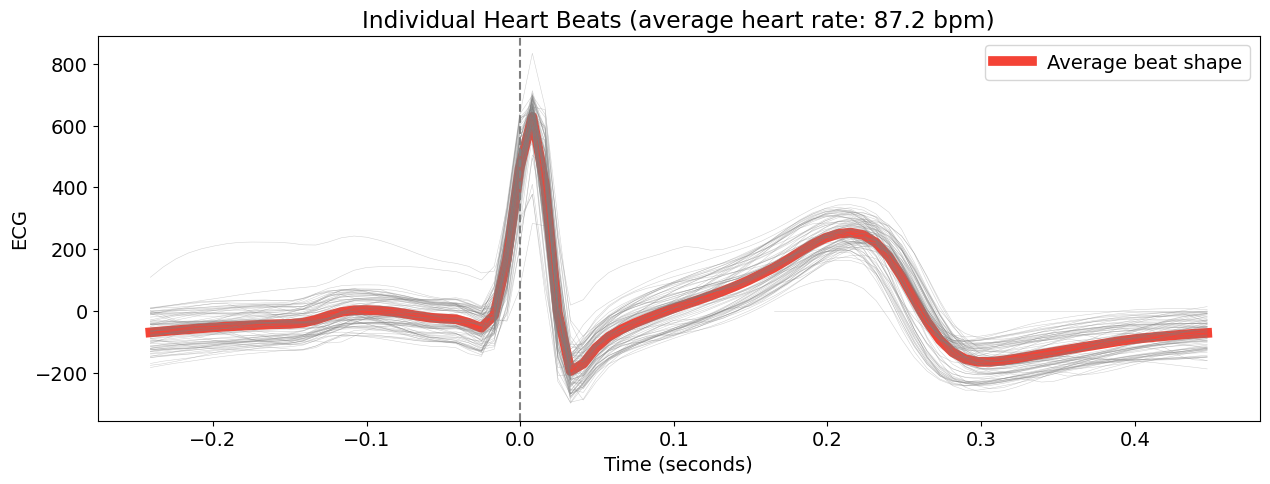

In [109]:
# Função da biblioteca para criação e plotagem dos Perfil
epochs = nk.ecg_segment(ecg_limpo, rpeaks=None, sampling_rate=sr, show=True)
plt.savefig (f'Pacientes/{nome_do_paciente}/Gráficos/Frequencia_Media', dpi=300)

## Reconhecimento dos outros picos (PQST)

Além dos picos R, o ECG possui outras ondas importantes que representam diferentes fases do ciclo cardíaco:

- **Onda P**: Representa a despolarização dos átrios, indicando que os átrios estão se contraindo.
- **Complexo QRS**: Representa a despolarização dos ventrículos, ou seja, a contração dos ventrículos.
- **Onda T**: Representa a repolarização dos ventrículos, que é o relaxamento após a contração.

A segmentação das ondas P, QRS e T é realizada para entender o comportamento detalhado do coração em cada fase do ciclo. Esta análise permite identificar possíveis anomalias no ciclo cardíaco, como variações na duração do complexo QRS ou alterações na amplitude das ondas, que podem ser indicativos de condições cardíacas.

c:\Users\andre23035\.conda\envs\pyecg\lib\site-packages\pandas\core\frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


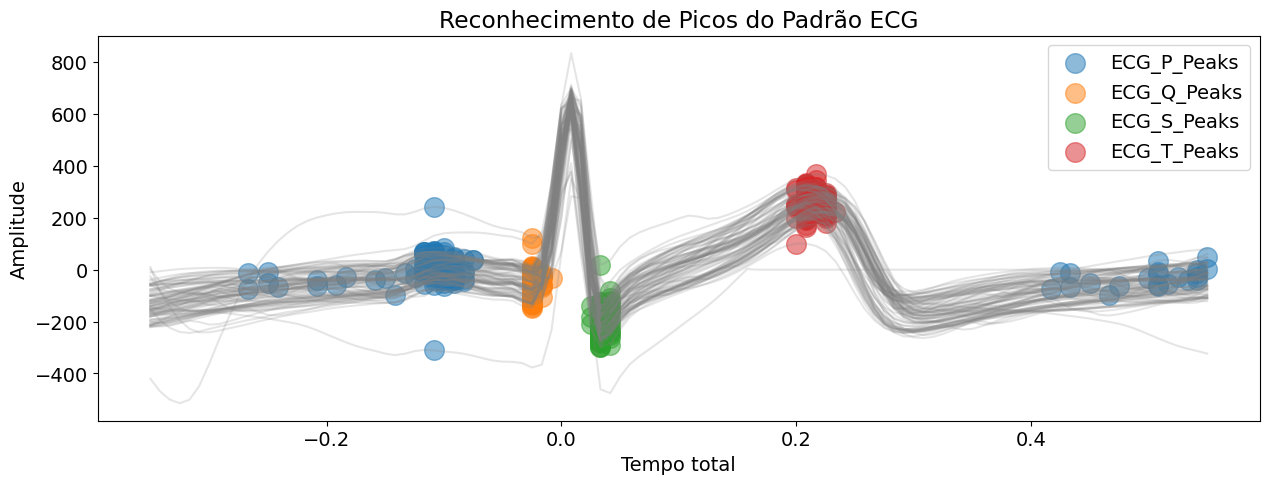

In [110]:
# Função da biblioteca para reconhecimento dos picos
signal_dwt, waves_dwt = nk.ecg_delineate(
    ecg_limpo,
    picos_r,
    sampling_rate=sr,
    method="dwt",
    show=True,
    show_type="peaks"
)

plt.xlabel("Tempo total")
plt.ylabel("Amplitude")
plt.title("Reconhecimento de Picos do Padrão ECG")
plt.legend()
plt.savefig (f'Pacientes/{nome_do_paciente}/Gráficos/Reconhecimento_Picos', dpi=300)
plt.show()

## Segmentação da Leitura

Podemos com isso, analisar temporalmente complicações na leitura, que podem ser doenças ou erros na eletrônica.

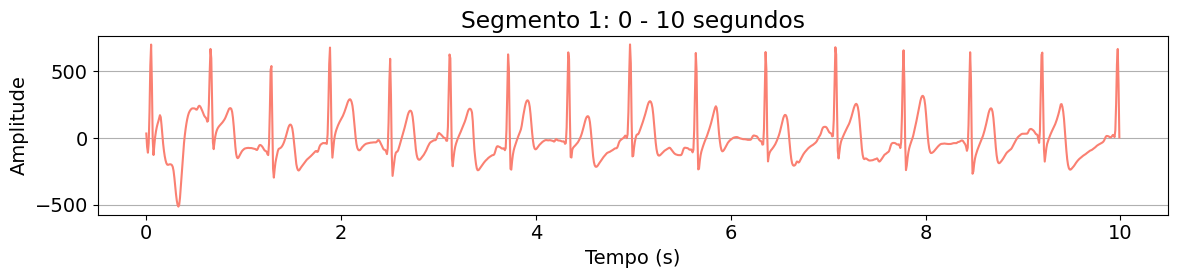

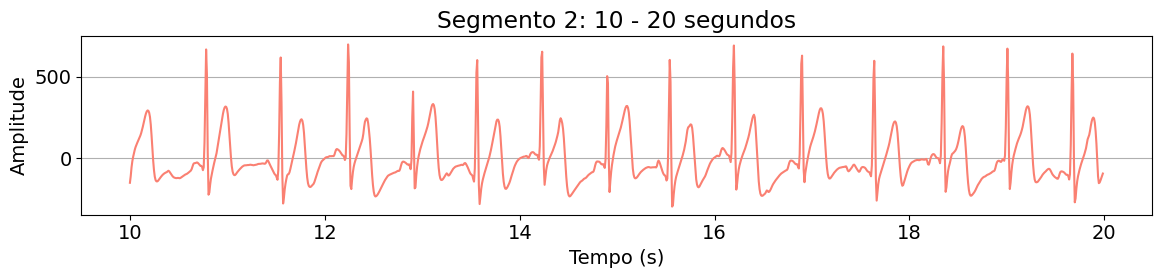

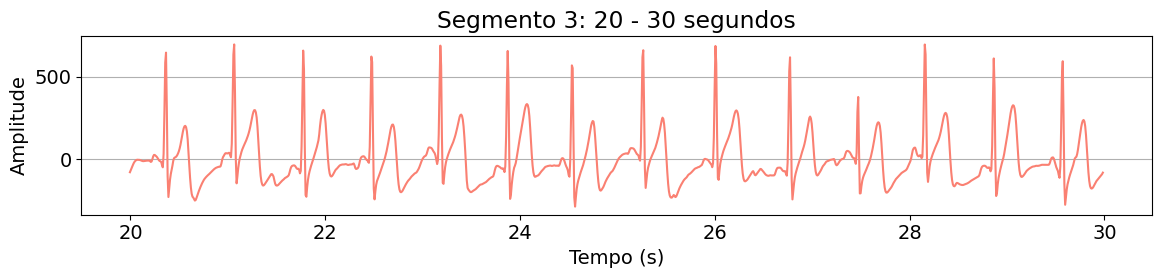

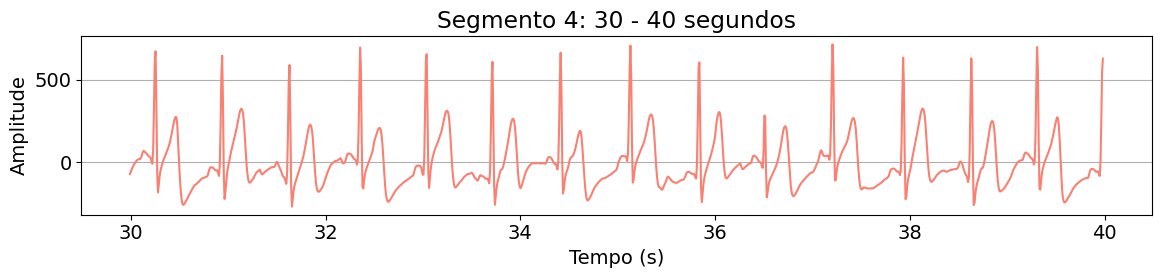

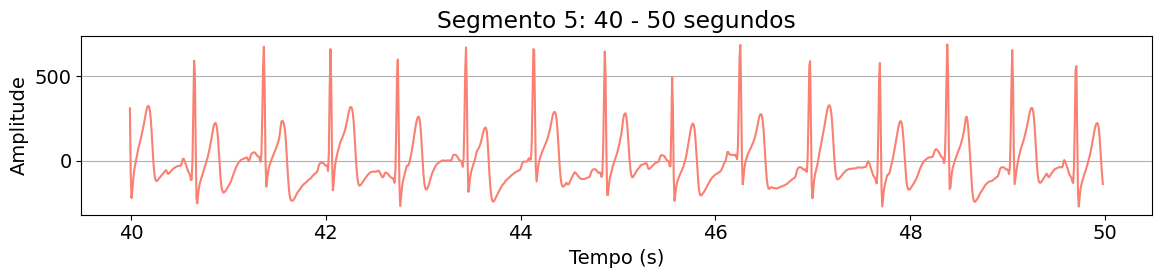

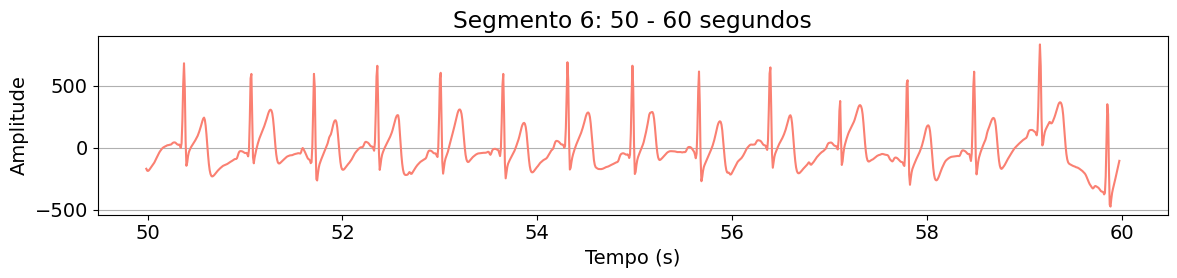

In [111]:
# Calcula os pontos de tempo no eixo X em segundos
tempo = np.linspace(0, duracao_total, len(sinal_n))  # Define o tempo baseado na duração total e no número de amostras

# Duração de cada segmento em segundos
segment_duration = 10
segment_samples = int(segment_duration * sr)  # Quantidade de amostras para 10 segundos

# Calcula o número de segmentos possíveis com base na duração total
num_segments = int(duracao_total / segment_duration)

# Cria gráficos para cada segmento de 10 segundos
for i in range(num_segments):
    plt.figure(figsize=(12, 3))  # Configuração para tamanho de cada gráfico
    start = i * segment_samples
    end = start + segment_samples
    segment_time = tempo[start:end]
    segment_ecg = sinais["ECG_Clean"][start:end]  # Usa o sinal limpo do NeuroKit2

    plt.plot(segment_time, segment_ecg, color="salmon")
    plt.title(f"Segmento {i + 1}: {i * segment_duration} - {(i + 1) * segment_duration} segundos")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Amplitude")
    plt.grid(axis="y")
    plt.tight_layout()
    plt.savefig (f'Pacientes/{nome_do_paciente}/Gráficos/Segmento{i + 1}', dpi=300)
    plt.show()  # Mostra cada gráfico individualmente



## Identificação dos Picos R

Um dos principais elementos de interesse no ECG são os **picos R**, que representam o momento de contração máxima dos ventrículos do coração. Esses picos são detectados automaticamente no sinal limpo e são utilizados para calcular a frequência cardíaca ao longo do tempo.

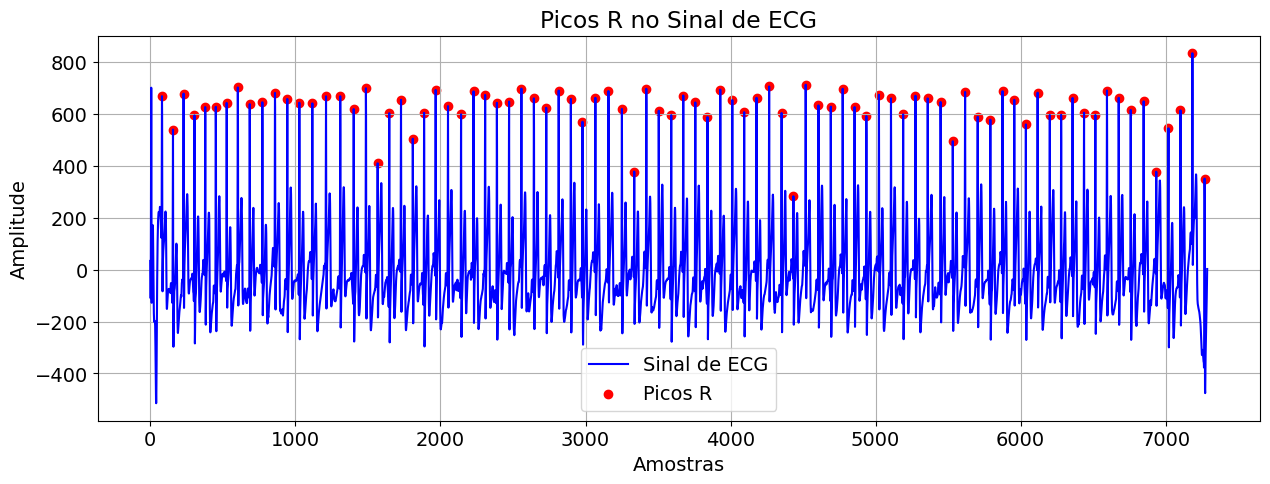

In [112]:
plt.plot(ecg_limpo, label="Sinal de ECG", color="blue")

# Adicionar os picos R no gráfico
plt.scatter(picos_r, ecg_limpo[picos_r], color="red", label="Picos R")

# Personalizar o gráfico
plt.title("Picos R no Sinal de ECG")
plt.xlabel("Amostras")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.savefig (f'Pacientes/{nome_do_paciente}/Gráficos/Picos_R', dpi=300)
plt.show()


## Detecção de Anomalias e Possíveis Arritmias

A **detecção de anomalias nos intervalos RR** é realizada para identificar possíveis arritmias cardíacas. Arritmias são alterações nos intervalos entre batimentos cardíacos, que podem indicar problemas como:

- **Bradicardia**: Intervalos RR maiores que o esperado, indicando frequência cardíaca lenta.
- **Taquicardia**: Intervalos RR menores que o esperado, indicando frequência cardíaca acelerada.
- **Intervalos Anômalos**: Intervalos RR que fogem muito do padrão podem indicar uma arritmia ou outros problemas cardíacos.

Para detectar anomalias, verificamos se o intervalo RR está fora dos limites normais, como intervalos menores que 0.6 segundos ou maiores que 1.2 segundos. Esses limites são baseados em parâmetros comuns de variação cardíaca e ajudam a sinalizar quando o ritmo cardíaco está fora do esperado.

In [115]:
# Detecção de arritmias usando variabilidade do intervalo RR
intervalos_rr = np.diff(picos_r) / sr  # Converte para segundos
intervalos_anomalos = intervalos_rr[(intervalos_rr < 0.6) | (intervalos_rr > 1.2)]
if len(intervalos_anomalos) > 0:
    print(f"Atenção: {len(intervalos_anomalos)} intervalos anômalos detectados.")
else:
    print("Nenhuma anomalia nos intervalos RR detectada.")

porcentagem_anom = len(intervalos_anomalos)/len(intervalos_rr)

print(f'A porcentagem de intervalos anômalos é:", {porcentagem_anom:.3f} %')


Nenhuma anomalia nos intervalos RR detectada.
A porcentagem de intervalos anômalos é:", 0.000 %
